## Import the necessary libraries

In [1]:
import numpy as np
import functools
import tensorflow as tf
import tensorflow.keras as keras
import tqdm
import scipy as sc
import scipy.io
import os
import matplotlib.pyplot as pyplot
import tensorflow_addons as tfa

# specify the gpu to be utilized
os.environ["CUDA_VISIBLE_DEVICES"]="3"

2023-01-06 14:52:34.342460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 14:52:34.472829: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## define the data and model parameters

In [2]:
# image size
height_crop_size = 160 
width_crop_size = 64
slice_size = 52

# model training parameters
batch_size = 1
epochs = 100
epoch_decay = epochs // 2 # number of epoch to start decaying the learning rate

# cycleGAN parameters
lr = 0.0002 # learning rate
beta_1 = 0.5 # weight
adversarial_loss_mode = 'lsgan' # choices = ['gan', 'hinge_v1', 'hinge_v2', 'lsgan', 'wgan']
gradient_penalty_mode = 'none' # choices = ['none', 'dragan', 'wgan-gp']
gradient_penalty_weight = 10.0
cycle_loss_weight = 10.0
identity_loss_weight = 2.0
pool_size = 50 # pool size of fake samples

## Load the training and test data sets

The data for each set consists of 909 images of 3D aortic anatomy, which were either obtained using CT angiography or 4D flow MRI. The peak systolic velocity for each set was also measured using 4D flow MRI. The anatomy and flow data have been pre-processed and are each sized at 192 x 64 x 64 pixels, representing the height, width, and slice dimensions, respectively

2023-01-06 14:52:38.179190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 14:52:39.001423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47205 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:d8:00.0, compute capability: 7.5


(1, 160, 64, 52)


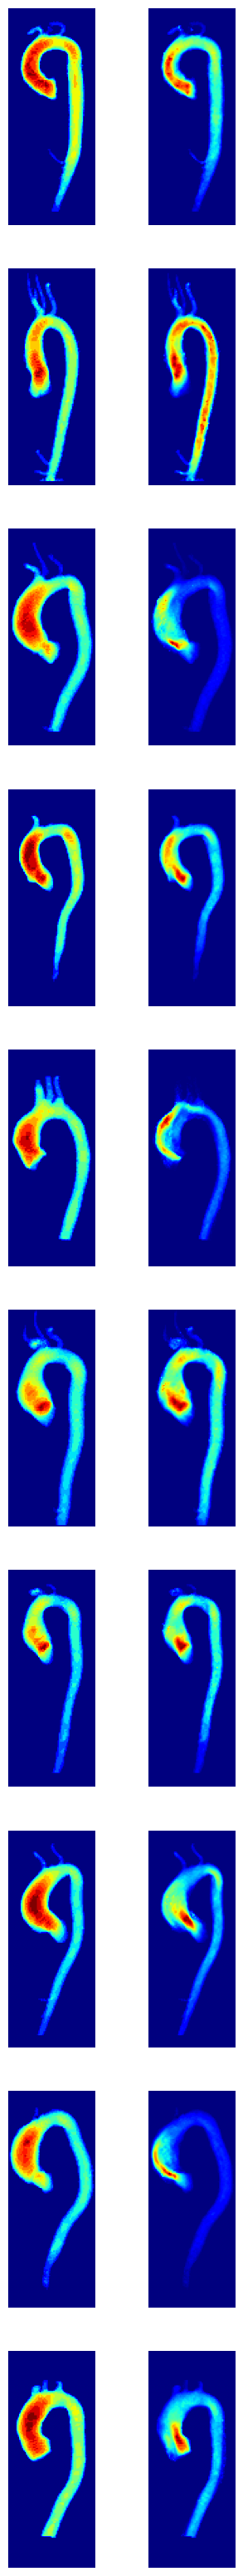

In [3]:
# crop the enlarged images back to original size around the center
@tf.function
def center_crop(image, size):
    if not isinstance(size, (tuple, list)):
        size = [size, ize]
    offset_height = (tf.shape(image)[-3]-size[0])//2
    offset_width = (tf.shape(image)[-2]-size[1])//2
    return tf.image.crop_to_bounding_box(image,offset_height,offset_width,size[0],size[1])

# define the mapping parser in tensorflow dataset pipline
def parser(tfrecord):
    feature = tf.io.parse_single_example(tfrecord,{'A': tf.io.FixedLenFeature(shape=[], dtype=tf.string),
              'B' : tf.io.FixedLenFeature(shape=[], dtype=tf.string),
              'height' : tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
              'width'  : tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
              'depth'  : tf.io.FixedLenFeature(shape=[], dtype=tf.int64)})
    height = tf.cast(feature["height"], tf.int32)
    width  = tf.cast(feature["width"], tf.int32)
    depth  = tf.cast(feature["depth"], tf.int32)
    A = tf.io.decode_raw(feature['A'], tf.float32) 
    A = tf.reshape(A, [height, width, depth])
    A = center_crop(A, [height_crop_size,width_crop_size])
    B = tf.io.decode_raw(feature['B'], tf.float32) 
    B = tf.reshape(B, [height, width, depth])
    B = center_crop(B, [height_crop_size,width_crop_size])
    return A, B

# training set directory
tfrecord_path = 'anatomay2flow_train.tfrecords'
dataset_train = tf.data.TFRecordDataset(tfrecord_path)
dataset_train = dataset_train.map(map_func=parser)
data_size = len(list(dataset_train))
dataset_train = dataset_train.shuffle(buffer_size=data_size)
dataset_train = dataset_train.batch(batch_size)
len_dataset = int(data_size/batch_size)

# test set directory
tfrecord_path = 'anatomay2flow_test.tfrecords'
dataset_test = tf.data.TFRecordDataset(tfrecord_path)
dataset_test = dataset_test.map(map_func=parser)
dataset_test = dataset_test.batch(1)
dataset_test = iter(dataset_test);

# create a batch of test sample to monitor the model performance while training
Asample = list()
Bsample = list()
ii = 0
for a,b in dataset_test:
    Asample.append(a)
    Bsample.append(b)
    ii+=1
    if ii>9:
        print(a.shape)
        break
        
# plot example images
n_samples = len(Asample)
pyplot.figure(figsize=(4,40))
for i in range(1,n_samples+1):
    anatomy = np.squeeze(Asample[i-1])
    pyplot.subplot(n_samples,2,2*i-1)
    pyplot.axis('off')
    pyplot.imshow(np.mean(anatomy,axis=-1),cmap='jet')
    # plot target image
for i in range(1,n_samples+1):
    flow = np.squeeze(Bsample[i-1])
    pyplot.subplot(n_samples,2,2*i)
    pyplot.axis('off')
    pyplot.imshow(np.mean(flow,axis=-1),cmap='jet')
pyplot.show()

## define the generators and discriminators

The CycleGAN involves the simultaneous training of two generator models and two discriminator models. One generator takes images from the CT domain as input and outputs images for the MRI domain, and the other generator takes images from the MRI domain as input and generates images for the CT domain. Discriminator models are then used to determine how plausible the generated images are and update the generator models accordingly.

### generator
The generator is an encoder-decoder model architecture. The model takes a CT image and generates a MRI image. It does this by first downsampling or encoding the CT image down to a bottleneck layer, then interpreting the encoding with a number of ResNet layers that use skip connections, followed by a series of layers that up sample or decode the representation to the size of the MRI data.
    
### discriminator
The discriminator design is based on the effective receptive field of the model, which defines the relationship between one output of the model to the number of pixels in the input image.

In [4]:
# define the different normalization options
def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return keras.layers.LayerNormalization

# define the resnet generators
def ResnetGenerator(input_shape=(None, None, None, 1),
                    output_channels=1,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = _get_norm_layer(norm)

    def _residual_block(x):
        dim = x.shape[-1]
        h = x
        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv3D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)
        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv3D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        return keras.layers.add([x, h])
    # 0
    h = inputs = keras.Input(shape=input_shape)
    # 1
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv3D(dim, 7, padding='valid', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)
    # 2
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv3D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)
    # 3
    for _ in range(n_blocks):
        h = _residual_block(h)
    # 4
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv3DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)
    # 5
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv3D(output_channels, 7, padding='valid',activation='linear')(h)
    return keras.Model(inputs=inputs, outputs=h)

# define the convolutional discriminator
def ConvDiscriminator(input_shape=(None, None, None, 1),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):
    dim_ = dim
    Norm = _get_norm_layer(norm)
    # 0
    h = inputs = keras.Input(shape=input_shape)
    # 1
    h = keras.layers.Conv3D(dim, 4, strides=2, padding='same')(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)
    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv3D(dim, 4, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)
    # 2
    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv3D(dim, 4, strides=1, padding='same', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)
    # 3
    h = keras.layers.Conv3D(1, 4, strides=1, padding='same')(h)
    return keras.Model(inputs=inputs, outputs=h)

# generators
G_A2B = ResnetGenerator(input_shape=(height_crop_size,width_crop_size,slice_size,1))
G_B2A = ResnetGenerator(input_shape=(height_crop_size,width_crop_size,slice_size,1))

# discriminators
D_A = ConvDiscriminator(input_shape=(height_crop_size,width_crop_size,slice_size,1))
D_B = ConvDiscriminator(input_shape=(height_crop_size,width_crop_size,slice_size,1))

## define the loss functions and optimizers for generator and discriminator models
each generator model is optimized via the combination of four outputs with four loss functions:

    Adversarial loss (L2 or mean squared error).
    Identity loss (L1 or mean absolute error).
    Forward cycle loss (L1 or mean absolute error).
    Backward cycle loss (L1 or mean absolute error).

This can be achieved by defining a composite model used to train each generator model that is responsible for only updating the weights of that generator model, although it is required to share the weights with the related discriminator model and the other generator model.

In [5]:
def get_lsgan_losses_fn():
    mse = tf.losses.MeanSquaredError()
    def d_loss_fn(r_logit, f_logit):
        r_loss = mse(tf.ones_like(r_logit), r_logit)
        f_loss = mse(tf.zeros_like(f_logit), f_logit)
        return r_loss, f_loss
    def g_loss_fn(f_logit):
        f_loss = mse(tf.ones_like(f_logit), f_logit)
        return f_loss
    return d_loss_fn, g_loss_fn
d_loss_fn, g_loss_fn = get_lsgan_losses_fn()
cycle_loss_fn = tf.losses.MeanAbsoluteError()
identity_loss_fn = tf.losses.MeanAbsoluteError()

# define the learning rate decay schedule 
class LinearDecay(keras.optimizers.schedules.LearningRateSchedule):
    # if `step` < `step_decay`: use fixed learning rate
    # else: linearly decay the learning rate to zero

    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) * (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate
G_lr_scheduler = LinearDecay(lr, epochs * len_dataset, epoch_decay * len_dataset)
D_lr_scheduler = LinearDecay(lr, epochs * len_dataset, epoch_decay * len_dataset)

# define the generator and discriminator optimizers
G_optimizer = keras.optimizers.Adam(learning_rate=G_lr_scheduler, beta_1=beta_1)
D_optimizer = keras.optimizers.Adam(learning_rate=D_lr_scheduler, beta_1=beta_1)

## training step

In [6]:
# the two generators are trained over the gradient loss, cycle loss, and identity loss
@tf.function
def train_G(A,B):
    with tf.GradientTape() as t:
        A2B = G_A2B(A, training=True)
        B2A = G_B2A(B, training=True)
        A2B2A = G_B2A(A2B, training=True)
        B2A2B = G_A2B(B2A, training=True)
        A2A = G_B2A(A, training=True)
        B2B = G_A2B(B, training=True)
        A2B_d_logits = D_B(A2B, training=True)
        B2A_d_logits = D_A(B2A, training=True)
        A2B_g_loss = g_loss_fn(A2B_d_logits)
        B2A_g_loss = g_loss_fn(B2A_d_logits)
        A2B2A_cycle_loss = cycle_loss_fn(A, A2B2A)
        B2A2B_cycle_loss = cycle_loss_fn(B, B2A2B)
        A2A_id_loss = identity_loss_fn(A, A2A)
        B2B_id_loss = identity_loss_fn(B, B2B)
        G_loss = (A2B_g_loss + B2A_g_loss) + (A2B2A_cycle_loss + B2A2B_cycle_loss) * cycle_loss_weight \
        + (A2A_id_loss + B2B_id_loss) * identity_loss_weight
    G_grad = t.gradient(G_loss, G_A2B.trainable_variables + G_B2A.trainable_variables)
    G_optimizer.apply_gradients(zip(G_grad, G_A2B.trainable_variables + G_B2A.trainable_variables))
    return A2B, B2A, {'A2B_g_loss': A2B_g_loss,
                      'B2A_g_loss': B2A_g_loss,
                      'A2B2A_cycle_loss': A2B2A_cycle_loss,
                      'B2A2B_cycle_loss': B2A2B_cycle_loss,
                      'A2A_id_loss': A2A_id_loss,
                      'B2B_id_loss': B2B_id_loss}

# train the discriminators
def gradient_penalty(f, real, fake, mode):
    def _gradient_penalty(f, real, fake=None):
        def _interpolate(a, b=None):
            if b is None:   # interpolation in DRAGAN
                beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter
        x = _interpolate(real, fake)
        with tf.GradientTape() as t:
            t.watch(x)
            pred = f(x)
        grad = t.gradient(pred, x)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)
        return gp
    if mode == 'none':
        gp = tf.constant(0, dtype=real.dtype)
    elif mode == 'dragan':
        gp = _gradient_penalty(f, real)
    elif mode == 'wgan-gp':
        gp = _gradient_penalty(f, real, fake)
    return gp
@tf.function

def train_D(A, B, A2B, B2A):
    with tf.GradientTape() as t:
        A_d_logits = D_A(A, training=True)
        B2A_d_logits = D_A(B2A, training=True)
        B_d_logits = D_B(B, training=True)
        A2B_d_logits = D_B(A2B, training=True)
        A_d_loss, B2A_d_loss = d_loss_fn(A_d_logits, B2A_d_logits)
        B_d_loss, A2B_d_loss = d_loss_fn(B_d_logits, A2B_d_logits)
        D_A_gp = gradient_penalty(functools.partial(D_A, training=True), A, \
                                      B2A, mode=gradient_penalty_mode)
        D_B_gp = gradient_penalty(functools.partial(D_B, training=True), B, \
                                      A2B, mode=gradient_penalty_mode)
        D_loss = (A_d_loss + B2A_d_loss) + (B_d_loss + A2B_d_loss) + (D_A_gp + D_B_gp) \
        * gradient_penalty_weight
    D_grad = t.gradient(D_loss, D_A.trainable_variables + D_B.trainable_variables)
    D_optimizer.apply_gradients(zip(D_grad, D_A.trainable_variables + D_B.trainable_variables))
    return {'A_d_loss': A_d_loss + B2A_d_loss,
            'B_d_loss': B_d_loss + A2B_d_loss,
            'D_A_gp': D_A_gp,
            'D_B_gp': D_B_gp}

# define a pool of fake samples
class ItemPool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.items = []
    def __call__(self, in_items):
        # `in_items` should be a batch tensor
        if self.pool_size == 0:
            return in_items
        out_items = []
        for in_item in in_items:
            if len(self.items) < self.pool_size:
                self.items.append(in_item)
                out_items.append(in_item)
            else:
                if np.random.rand() > 0.5:
                    idx = np.random.randint(0, len(self.items))
                    out_item, self.items[idx] = self.items[idx], in_item
                    out_items.append(out_item)
                else:
                    out_items.append(in_item)
        return tf.stack(out_items, axis=0)
A2B_pool = ItemPool(pool_size)
B2A_pool = ItemPool(pool_size)

def train_step(A, B):
    A2B, B2A, G_loss_dict = train_G(A, B)
    # cannot autograph `A2B_pool`
    A2B = A2B_pool(A2B)  # or A2B = A2B_pool(A2B.numpy()), but it is much slower
    B2A = B2A_pool(B2A)  # because of the communication between CPU and GPU
    D_loss_dict = train_D(A, B, A2B, B2A)
    return G_loss_dict, D_loss_dict

@tf.function
def sample(A, B):
    A2B = G_A2B(A, training=False)
    B2A = G_B2A(B, training=False)
    A2B2A = G_B2A(A2B, training=False)
    B2A2B = G_A2B(B2A, training=False)
    return A2B, B2A, A2B2A, B2A2B

## Run the model

In [ ]:
# create  an output directory
output_dir = './cycle_gan_output' # the directory to save the model outputs
if not tf.io.gfile.isdir(output_dir):
    tf.io.gfile.mkdir(output_dir) # if the output directory does not exist, creates it
    
# epoch counter
ep_cnt = tf.Variable(initial_value=0,trainable=False,dtype=tf.int64)

# checkpoint
class Checkpoint:
    """Enhanced "tf.train.Checkpoint"."""
    def __init__(self,
                 checkpoint_kwargs,  # for "tf.train.Checkpoint"
                 directory,  # for "tf.train.CheckpointManager"
                 max_to_keep=5,
                 keep_checkpoint_every_n_hours=None):
        self.checkpoint = tf.train.Checkpoint(**checkpoint_kwargs)
        self.manager = tf.train.CheckpointManager(self.checkpoint, directory, max_to_keep, keep_checkpoint_every_n_hours)
    def restore(self, save_path=None):
        save_path = self.manager.latest_checkpoint if save_path is None else save_path
        return self.checkpoint.restore(save_path)
    def save(self, file_prefix_or_checkpoint_number=None, session=None):
        if isinstance(file_prefix_or_checkpoint_number, str):
            return self.checkpoint.save(file_prefix_or_checkpoint_number, session=session)
        else:
            return self.manager.save(checkpoint_number=file_prefix_or_checkpoint_number)
    def __getattr__(self, attr):
        if hasattr(self.checkpoint, attr):
            return getattr(self.checkpoint, attr)
        elif hasattr(self.manager, attr):
            return getattr(self.manager, attr)
        else:
            self.__getattribute__(attr)  # this will raise an exception

checkpoint = Checkpoint(dict(G_A2B=G_A2B,
                                G_B2A=G_B2A,
                                D_A=D_A,
                                D_B=D_B,
                                G_optimizer=G_optimizer,
                                D_optimizer=D_optimizer,
                                ep_cnt=ep_cnt),
                          tf.io.gfile.join(output_dir,'checkpoints'),
                          max_to_keep=5)
try:  # restore checkpoint including the epoch counter
     checkpoint.restore().assert_existing_objects_matched()
except Exception as e:
     print(e)
        
# summary
def summary(name_data_dict,
            step=None,
            types=['mean', 'std', 'max', 'min', 'sparsity', 'histogram'],
            historgram_buckets=None,
            name='summary'):

    def _summary(name, data):
        if data.shape == ():
            tf.summary.scalar(name, data, step=step)
        else:
            if 'mean' in types:
                tf.summary.scalar(name + '-mean', tf.math.reduce_mean(data), step=step)
            if 'std' in types:
                tf.summary.scalar(name + '-std', tf.math.reduce_std(data), step=step)
            if 'max' in types:
                tf.summary.scalar(name + '-max', tf.math.reduce_max(data), step=step)
            if 'min' in types:
                tf.summary.scalar(name + '-min', tf.math.reduce_min(data), step=step)
            if 'sparsity' in types:
                tf.summary.scalar(name + '-sparsity', tf.math.zero_fraction(data), step=step)
            if 'histogram' in types:
                tf.summary.histogram(name, data, step=step, buckets=historgram_buckets)
    with tf.name_scope(name):
        for name, data in name_data_dict.items():
            _summary(name, data)
train_summary_writer = tf.summary.create_file_writer(tf.io.gfile.join(output_dir,'summaries'))

# main loop
with train_summary_writer.as_default():
    for ep in tqdm.trange(epochs, desc='Epoch Loop', total=epochs):
        if ep < ep_cnt:
            continue
        # update epoch counter
        ep_cnt.assign_add(1)
        # train for an epoch
        for A, B in tqdm.tqdm(dataset_train, desc='Inner Epoch Loop', total=len_dataset):
            G_loss_dict, D_loss_dict = train_step(A, B)
            # summary
            summary(G_loss_dict, step=G_optimizer.iterations, name='G_losses')
            summary(D_loss_dict, step=G_optimizer.iterations, name='D_losses')
            summary({'learning rate': G_lr_scheduler.current_learning_rate}, step=G_optimizer.iterations, 
                       name='learning rate')
        for ii in range(len(Asample)):
            A = tf.reshape(Asample[ii], (1,height_crop_size,width_crop_size,slice_size,1))
            B = tf.reshape(Bsample[ii], (1,height_crop_size,width_crop_size,slice_size,1))
            A2B, B2A, A2B2A, B2A2B = sample(A, B)
            anatomy = np.squeeze(A.numpy())
            flow = np.squeeze(B.numpy())
            anatomy2flow = np.squeeze(A2B.numpy())  
            flow2anatomy = np.squeeze(B2A.numpy())
            anatomy2flow2anatomy = np.squeeze(A2B2A.numpy())
            flow2anatomy2flow = np.squeeze(B2A2B.numpy()) 
            filename1 = py.join(sample_dir,'iter-%03u-%02u.mat' % (ep,ii))
            scipy.io.savemat(filename1,{'anatomy':anatomy,
                            'flow':flow,
                            'anatomy2flow':anatomy2flow,
                            'flow2anatomy':flow2anatomy,
                            'anatomy2flow2anatomy':anatomy2flow2anatomy,
                            'flow2anatomy2flow':flow2anatomy2flow})
        # save checkpoint
        checkpoint.save(ep)

No checkpoint specified (save_path=None); nothing is being restored.


Inner Epoch Loop:   0%|                                 | 0/909 [00:00<?, ?it/s]2023-01-06 14:53:13.464469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 463 of 909
2023-01-06 14:53:23.461376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 858 of 909
2023-01-06 14:53:24.743750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-01-06 14:53:50.097156: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-01-06 14:53:51.433560: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-01-06 14:53:51.653903: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This 